In [23]:
import sys
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np
import skimage.data as skd
from skimage.transform import resize
from PIL import Image
import selectivesearch 
import matplotlib.patches as mpatches
from collections import OrderedDict
import IPython.display as display
%matplotlib inline

use_gpu=False

# <font size=10 color=blue>Визуализация и осознание</font>
Цель - понять что творится под капотом у конволюционных сетей. 

![AlexNet](./img/alexnet.png)
Матрица весов входноного слоя имеет размерность __ 3x11x11x64 __. Следуя интуиции: входной слой будет реагировать на те элементы входного изображения сктруктура которых близка к структуре фильтра. Поскольку мы используем _ скалярное произведение _ для вычисления активации 

## Визуализация фильтров AlexNet

In [6]:
# pretrained = True - закачаем уже предобученную модель
AlexNet = models.alexnet(pretrained=True)
AlexNet.eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\vkrin/.cache\torch\checkpoints\alexnet-owt-4df8aa71.pth
100%|███████████████████████████████████████████████████████████████████████████████| 233M/233M [00:22<00:00, 11.0MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

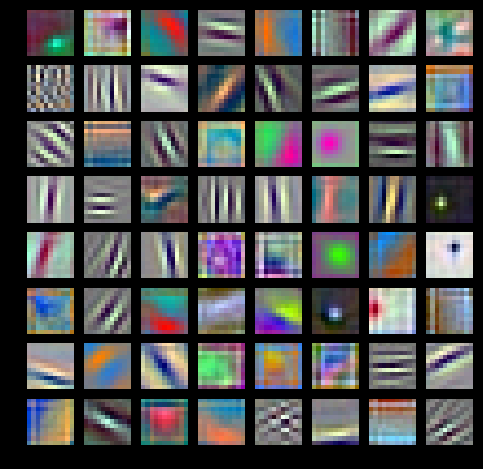

In [7]:
net = AlexNet.features
figure  = plt.figure(64, (8, 8), facecolor='black')
relu = torch.nn.ReLU()
for panel  in range(0, net[0].weight.size(0)):
    ax = plt.subplot(8,8, panel+1)
    plt.axis('off')
    data = net[0].weight[panel]
    data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))
    plt.imshow(  data.transpose(0,1).transpose(1,2).data.numpy())


---
## Визуализация фильтров первого слоя ResNet-18 

In [8]:
ResNet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\vkrin/.cache\torch\checkpoints\resnet18-5c106cde.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:04<00:00, 10.7MB/s]


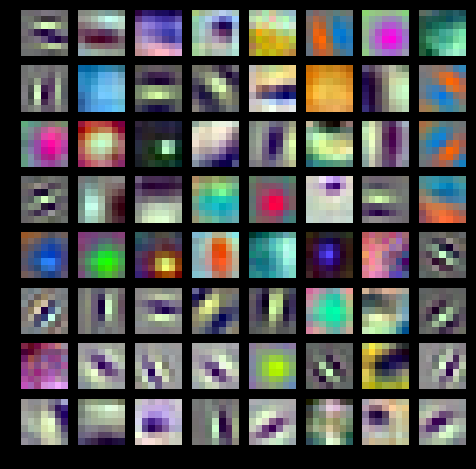

In [9]:
net = ResNet18.conv1
figure  = plt.figure(64, (8, 8), facecolor='black')

for panel  in range(0, net.weight.size(0)):
    ax = plt.subplot(8,8, panel+1)
    plt.axis('off')
    data = net.weight[panel]
    data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))
    plt.imshow(  data.transpose(0,1).transpose(1,2).data.numpy())
 

---
## Визуализация фильтров первого слоя ResNet-101

In [10]:
ResNet101 = models.resnet101(pretrained=True)

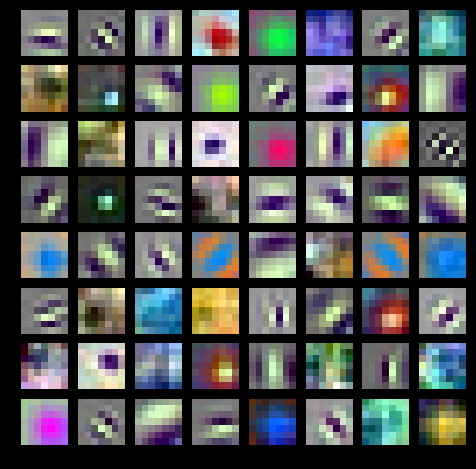

In [11]:
net = ResNet101.conv1
figure  = plt.figure(64, (8, 8), facecolor='black')

for panel  in range(0, net.weight.size(0)):
    ax = plt.subplot(8,8, panel+1)
    plt.axis('off')
    data = net.weight[panel]
    data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))
    plt.imshow(  data.transpose(0,1).transpose(1,2).data.numpy())


---
## Визуализация фильтров первого слоя DenseNet-121

In [12]:
DenseNet121 = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\vkrin/.cache\torch\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:03<00:00, 9.38MB/s]


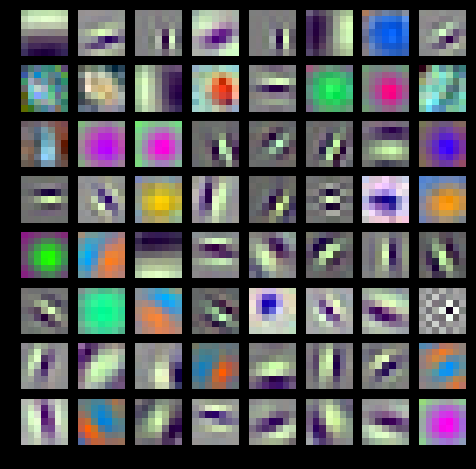

In [13]:
net = DenseNet121.features[0]
figure  = plt.figure(64, (8, 8), facecolor='black')

for panel  in range(0, net.weight.size(0)):
    ax = plt.subplot(8,8, panel+1)
    plt.axis('off')
    data = net.weight[panel]
    data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))
    plt.imshow(  data.transpose(0,1).transpose(1,2).data.numpy())


---
Конволюционные фичи первого слоя достаточно хорошо интерпретируемы. Т.е. они представляют собой простые фильтры, которые позволяют детектить ориентированные границы под разными углами. Подобно тому,  как это  делает человеческая система восприятия на ранних на ранних "слоях".

<font color=red size=5>Можно ли визуализировать фильтры на остальных слоях сети?</font>

### Проблеммы
1. Количество входных фильтров для каждого больше чем __ 3 __ . Поэтому, не получится интерпретировать фильтр как картинку

Можно пытаться изображать фильтры в ЧБ варианте 

In [14]:
def plot_filters(layer):
    figure  = plt.figure(64, (5, 5), facecolor='black')
     
    net = layer.weight[0]
    
    for panel  in range(0, min( net.size(0), 64)):
        ax = plt.subplot(8,8, panel+1)
        plt.axis('off')
        data = net[panel].unsqueeze(0)
        data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))
        #data = torch.cat((data, data, data), 0)
        plt.imshow(  data.transpose(0,1).transpose(1,2).squeeze(2).data.numpy(), cmap='Greys')

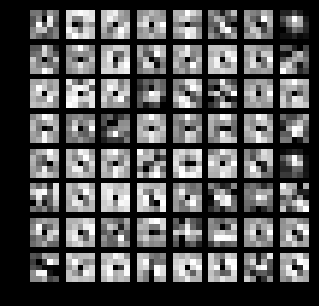

In [15]:
plot_filters ( AlexNet.features[3]) 

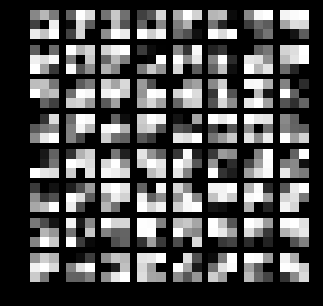

In [16]:
plot_filters ( AlexNet.features[6]) 

- Визуализация фильтров второго и последующих слоев оказалась не интерпритируема 


---
# Что придумали
---
В ["Rich feature hierarchies for accurate object detection and semantic segmentation"](https://arxiv.org/pdf/1311.2524.pdf)
предложили следующий подход к визуализации верхних слоев сети:
- Выбираем канал (feature map), например, 15 канал на пятом слое макспулинга AlexNet из 128 (оригинальный)

In [17]:
# В нашем случае 256
print ( 'Количество каналов на пятом слое MaxPooling, в нашем случае', AlexNet.features[10].out_channels)

Количество каналов на пятом слое MaxPooling, в нашем случае 256


* Прогоняем много изображений через сеть и регистрируем значения выходов на каждом канале
* По максимальным активациям отбираем те __ патчи __ которые привели к активациям конкретных выходов в канале

<font color=red size=5>Что такое патчи и как их получить? </font>

# Selective search
Для поиска кандидатов объектов на изображении используют специальные алгоритмы группирующие регионы пикселей, например, [Selective Search](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf). Алгоритм позволяет получить регионы изображения, в которых наиболее вероятно будут находится объекты.
<br/><br/>

Пример:
(используем библиотеку [selectivesearch](https://github.com/AlpacaDB/selectivesearch))

In [18]:
img = skd.astronaut()

In [19]:
def do_selective_search(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=500, sigma=0.9, min_size=10)
    candidates = set()
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 2000:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if w / h > 1.2 or h / w > 1.2:
            continue
        candidates.add(r['rect'])

    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img)
    for x, y, w, h in candidates:
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()
    return candidates

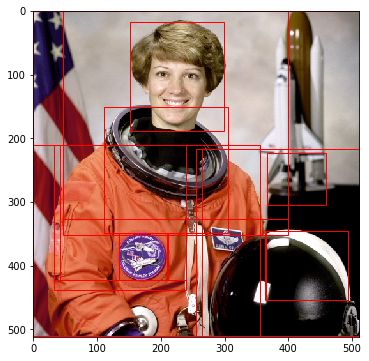

In [20]:
patch_cand = do_selective_search(img)

После разбивки изображения на патчи, прогоняим их через AlexNet и регестрируем активность нужных нам выходов канала

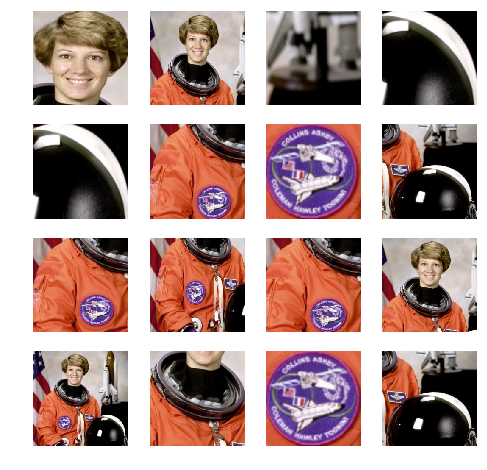

In [24]:
image_patches = []
figure  = plt.figure(len(patch_cand), (8, 8))
sx = sy = np.sqrt( len(patch_cand) )
for panel, (x, y, w, h)  in enumerate( patch_cand) :
    ax = plt.subplot(sx,sy, panel+1)
    plt.axis('off')
    data = resize(img[y:y+h, x:x+w ],(224,224))
    image_patches.append(data) # массив наших патчей
    plt.imshow( data)

Маленький классик для вытаскивания верхнего слоя из без нарушения структуры

In [25]:
class AlexNetLastPool(nn.Module):
    
    def __init__(self, alex_net):
        super(AlexNetLastPool, self).__init__()
        self.net = alex_net.features

    def forward(self, input):
            out = self.net(input)
            return out

In [26]:
spyNet = AlexNetLastPool(AlexNet)

> The images have to be loaded in to a range of [0, 1] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

In [35]:
mean=[0.485, 0.456, 0.406] 
std=[0.229, 0.224, 0.225]
trans = transforms.Compose([transforms.ToPILImage(),
                         transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

In [36]:
in_img = torch.from_numpy(image_patches[0] / 255 ).transpose(2,1).transpose(1,0).unsqueeze(0).float()
print ("Конвертируем картинку в торч формат", in_img.size())
# нормализация и оборачивание в Variable
in_img = Variable(trans( in_img))
# прогоняем через сеть
out = spyNet(in_img)
print("Выход каналов : ", out.size())
m_c, r = torch.max(out[0,19],0)
m , c = torch.max(m_c,0)
print("Максимум на 19-ом канале:", ( r[c[0]].data[0], c[0].data[0] ), " Значение: %0.4f"% m.data[0] )

Конвертируем картинку в торч формат torch.Size([1, 3, 224, 224])


ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

Можем зафиксировать этот выход и прогнать через сеть еще миллион различных патчей, отсортировать пачи по уровню активации в этом выходе и получим элементы изображений, на которых это выход получает максимальную активацию. 
## Вот что в результате
![VisualByPatches](./img/VisualbyPatches.png)

 __ Кстати, на этих же принципах работает R-CNN, для выделения объектов на картинке __
![DetectionRCNN](./img/Detection04.png)

## Метод патчей имеет слишком много недостатков:
* Базируется на патчах созданных другими методами => не точно показывает рецептивную область сети
* Слишком тяжел. По одной картинке понять, на что смотрит сеть не получится

## Что если не показывать, а закрывать часть картинки?
В [Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf) рассматривают такой метод, последовательно зануляя часть изображения и строя карту вероятностей класса картинки.
![ZeroPatch](./img/ZeroPatches.png)

В результате мы получаем области (синий цвет), при вырезании которых качество классификации падает. 

# Saliency Maps
[Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf)

Идея посмомтреть как влияют небольшие изменения входных пикселей на изменение градиета, и в итоге на изменение предсказания класса. Для этого нам
* нужно прогнать нашу картинку через сеть,
* далее по нужному нам классу обратным проходом по сети получить градиент (его размер будет такой же, как размер картинки)
* нормализовать его значения. 
<br/>Максимальные значения градиента будут соответствовать пикселям изображения, которые оказывают максимальное влиение на класс 

In [22]:
img_cat =  np.asarray(Image.open('./img/cat.jpg'))

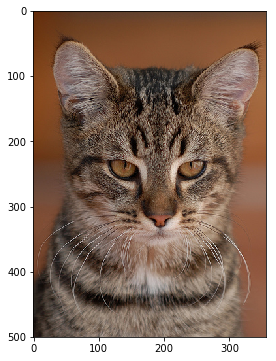

In [23]:
def show_cat(img, cmap=None):
    _, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img, cmap=cmap)
    plt.show()
show_cat(img_cat)

 - Прогоняем нашего котика через сетку

In [24]:
ow = img_cat.shape[0]
oh = img_cat.shape[1]
img_cat = imresize(img_cat, [224, 224]) / 255
in_img = torch.from_numpy(img_cat ).transpose(2,1).transpose(1,0).unsqueeze(0).float()
# Конвертируем картинку в торч формат
# нормализация и оборачивание в Variable
in_img = Variable(trans( in_img), requires_grad=True) # тут нам нужен будет градиент
# прогоняем через сеть
out = AlexNet(in_img)

- Выход равен количеству классов в ImageNet

In [25]:
out.size()

torch.Size([1, 1000])

- Максимум должен быть 282 - котик тигровый

In [26]:
val, idx = torch.max(out, 1)
print('Значение: %0.4f'%val.data[0], ' Индекс:', idx.data[0])

Значение: 19.2616  Индекс: 282


* Оставляем на выходе только значение того класса, которое нам нужно (281)
* Считаем градиент по входу

In [27]:
one_hot = np.zeros((1, out.size()[-1]), dtype=np.float32)
one_hot[0][idx.data[0]] = 1
one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
one_hot = torch.sum(one_hot * out)
one_hot.backward(retain_variables=True) # True = не чистим градиент по завершении

C:\Users\d.soloviev\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\autograd\__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


* Магические пассы, для вытаскивания градиента, его нормализации и превращения в картинку

In [28]:
grad = in_img.grad.data
grad = grad[0, :, :, :]
grad =  grad.transpose(0,1).transpose(1,2).numpy()

In [29]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [30]:
grad = rgb2gray(grad)
span = np.abs(np.percentile(grad, 95))
gmin = -span
gmax = span
grad = np.clip((grad - gmin) / (gmax - gmin), -1, 1)

* Что получилось. Мы получили пиксели, и уровень их воздействия на класс

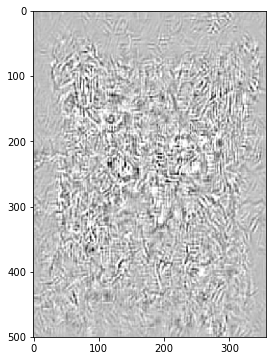

In [31]:
grad = imresize(grad, [ow, oh])
show_cat(grad, cmap='gray')

# Сглаженный градиент
[SmoothGrad: removing noise by adding noise](https://arxiv.org/pdf/1706.03825.pdf)
Предыдущий подход, позволяет находить область, на которую смотрит сеть, но эта область получается достаточно шумной. Можно убрать лишний шум добавив немного шума. Идея метода, итеративно накапливать градиент, немного меняя на каждой итерации входное изображение. Таким образом мы стабилизируем градиет в тех точках, в которых есть устойчивый ответ сети

---

Выводим картинку с шумом. 

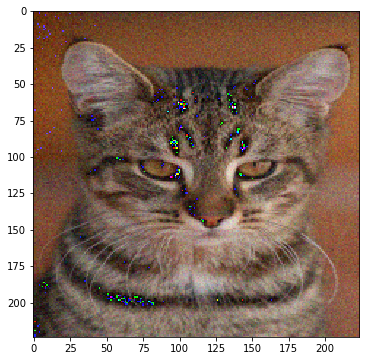

In [32]:
# количество итераций 
iterations = 25
total_gradients = np.zeros_like(img_cat)
stdev = 0.05 * (np.max(img_cat) - np.min(img_cat))
noise = np.random.normal(0, stdev, img_cat.shape).astype(np.float32)
cat_plus_noise = img_cat  + noise
show_cat(cat_plus_noise)

Делаем, ровно тоже самое, что и в предыдущем случае, но итеративно подмешиваем шум на каждой итерации

In [33]:
for i in range(0, iterations):
    noise = np.random.normal(0, stdev, img_cat.shape).astype(np.float32)
    cat_plus_noise = img_cat + noise
    cat_plus_noise = torch.from_numpy(cat_plus_noise ).transpose(2,1).transpose(1,0).unsqueeze(0).float()
    cat_plus_noise = Variable(cat_plus_noise, requires_grad=True)
    out = AlexNet(cat_plus_noise)
    val, idx = torch.max(out, 1)
    
    # считаем градиент по входу
    one_hot = np.zeros((1, out.size()[-1]), dtype=np.float32)
    one_hot[0][idx.data[0]] = 1
    one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
    one_hot = torch.sum(one_hot * out)
    
    one_hot.backward(retain_variables=True) # True = не чистим градиент по завершении
    
    
    grad = cat_plus_noise.grad.data
    grad = grad[0, :, :, :]
    grad = grad.transpose(0,1).transpose(1,2).numpy()

    total_gradients += grad
    
avg_gradients = total_gradients / iterations

C:\Users\d.soloviev\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\autograd\__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


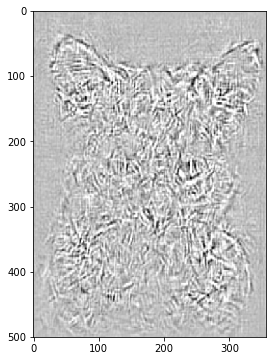

In [34]:
grad = rgb2gray(avg_gradients)
span = np.abs(np.percentile(grad, 95))
gmin = -span
gmax = span
grad = np.clip((grad - gmin) / (gmax - gmin), -1, 1)
grad = imresize(grad, [ow, oh])
show_cat(grad, cmap='gray')

# Guided backprop
* Основная идея:  рассматриваем нейроны как детекторы конкретных свойств изображения
* Нам интересно какие фичи изображения выделяет конкретный нейрон, нам не интересно, что нейрон не может детектить 
* Исходя из этого мы можем занулить отрицательный градиент приходящий в нейрон.
    * Нам все равно подавляет ли пиксель активность данного нейрона. 


![GuidedBackprop](./img/GuidedBackProp.png)



Поскольку нам нужно условие блокировки отрицательного градиента при прохождении через ReLU слои, нам потребуется класс, реализующий это условие

In [28]:
class GuidedBackpropReLU(torch.autograd.Function):

    def __init__(self, inplace=False):
        super(GuidedBackpropReLU, self).__init__()
        self.inplace = inplace

    def forward(self, input):
        # реализуем обычную логику релу, пропускаем значения больше 0
        pos_mask = (input > 0).type_as(input)
        output = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            input,
            pos_mask)
        # сохраняем получившийся выход и вход
        self.save_for_backward(input, output)
        return output

    def backward(self, grad_output):
        input, output = self.saved_tensors

        #
        # получаем маски для градиента, и входа, по которым будем занулять значения
        #
        pos_mask_1 = (input > 0).type_as(grad_output)
        pos_mask_2 = (grad_output > 0).type_as(grad_output)
        
        # пропускаем только градиент там, где значения в масках не нулевые
        grad_input = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            torch.addcmul(
                torch.zeros(input.size()).type_as(input), grad_output, pos_mask_1),
                pos_mask_2)

        return grad_input

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + ' (' \
            + inplace_str + ')'
        

Меняем релу модули в AlexNet на объект нашего класса

In [36]:
for idx, module in AlexNet.features._modules.items():
    if module.__class__.__name__ is 'ReLU':
        AlexNet.features._modules[idx] = GuidedBackpropReLU()

Copy-Paste - Из обычной _ Saliency Maps _

In [37]:
img_cat =  np.asarray(Image.open('./img/cat.jpg'))

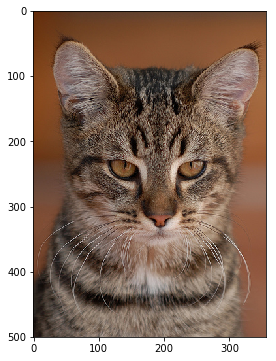

In [38]:
def show_cat(img, cmap=None):
    _, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img, cmap=cmap)
    plt.show()
show_cat(img_cat)

 - Прогоняем нашего котика через сетку

In [39]:
ow = img_cat.shape[0]
oh = img_cat.shape[1]
img_cat = imresize(img_cat, [224, 224]) / 255
in_img = torch.from_numpy(img_cat ).transpose(2,1).transpose(1,0).unsqueeze(0).float()
# Конвертируем картинку в торч формат
# нормализация и оборачивание в Variable
in_img = Variable(trans( in_img), requires_grad=True) # тут нам нужен будет градиент
# прогоняем через сеть
out = AlexNet(in_img)

- Выход равен количеству классов в ImageNet

In [40]:
out.size()

torch.Size([1, 1000])

- Максимум должен быть 282 - котик тигровый

In [41]:
val, idx = torch.max(out, 1)
print('Значение: %0.4f'%val.data[0], ' Индекс:', idx.data[0])

Значение: 19.2616  Индекс: 282


* Оставляем на выходе только значение того класса, которое нам нужно (282)
* Считаем градиент по входу

In [42]:
one_hot = np.zeros((1, out.size()[-1]), dtype=np.float32)
one_hot[0][idx.data[0]] = 1
one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
one_hot = torch.sum(one_hot * out)
one_hot.backward(retain_variables=True) # True = не чистим градиент по завершении

C:\Users\d.soloviev\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\autograd\__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


* Магические пассы, для вытаскивания градиента, его нормализации и превращения в картинку

In [43]:
grad = in_img.grad.data
grad = grad[0, :, :, :]
grad =  grad.transpose(0,1).transpose(1,2).numpy()

In [44]:
grad = rgb2gray(grad)
span = np.abs(np.percentile(grad, 95))
gmin = -span
gmax = span
grad = np.clip((grad - gmin) / (gmax - gmin), -1, 1)

* Что получилось. Мы получили пиксели, и уровень их воздействия на класс

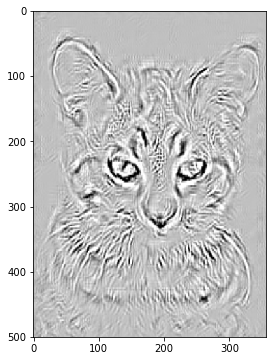

In [45]:
grad = imresize(grad, [ow, oh])
show_cat(grad, cmap='gray')

Вернем Relu элементы обратно

In [14]:
for idx, module in AlexNet.features._modules.items():
    if module.__class__.__name__ is 'GuidedBackpropReLU':
        AlexNet.features._modules[idx] = nn.ReLU()

Таким же образом можно рассмотреть, что происходит в слоях сети на каналах и отдельных нейронах. Для этого реализуем класс который копируем обученные слои, до нужного нам, из AlexNet

In [47]:
import copy

class FeaturesExtractor(nn.Module):
    
        def __init__(self, input_features, layer_idx=12): # 1, 4, 7, 9, 12
            
            super(FeaturesExtractor, self).__init__()
            mods = OrderedDict()

            for i in range(0, layer_idx):
                mods[ str(i)] = copy.deepcopy(input_features[i])
                
            self.features = nn.Sequential(mods)
            
            for idx, module in self.features._modules.items():
                if module.__class__.__name__ is 'ReLU':
                    self.features._modules[idx] = GuidedBackpropReLU()            
            
        def forward(self, input):
            return self.features(input)

Реализуем функцию для показа каналов заданного слоя

In [48]:
def show_feature_maps(img_cat, layer_idx):
    features_extractor = FeaturesExtractor(AlexNet.features, layer_idx)
            
    ow = img_cat.shape[0]
    oh = img_cat.shape[1]
    img_cat = imresize(img_cat, [224, 224]) / 255
    outpanels = []
    for fm in range(0, 16):
        in_img = torch.from_numpy(img_cat ).transpose(2,1).transpose(1,0).unsqueeze(0).float()
        in_img = Variable(trans( in_img), requires_grad=True) # тут нам нужен будет градиент
        out = features_extractor(in_img)
        one_hot = np.zeros( out.size(), dtype=np.float32)
        one_hot[:,fm,:,:] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
        one_hot = torch.sum(one_hot * out)
        one_hot.backward(retain_variables=True)
        grad = in_img.grad.data
        grad = grad[0, :, :, :]
        grad =  grad.transpose(0,1).transpose(1,2).numpy()
        outpanels.append(grad)
        
    figure  = plt.figure(16, (12, 12), facecolor='black')
    relu = torch.nn.ReLU()
    for panel  in range(0, 16):
        ax = plt.subplot(4,4, panel+1)
        plt.axis('off')
        grad = outpanels[panel]
        span = np.abs(np.percentile(grad, 95))
        gmin = -span
        gmax = span
        grad = np.clip((grad - gmin) / (gmax - gmin), -1, 1)
        plt.imshow(  grad )

In [49]:
img_cat =  np.asarray(Image.open('./img/cat.jpg'))

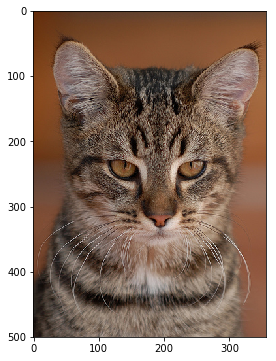

In [50]:
def show_cat(img, cmap=None):
    _, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img, cmap=cmap)
    plt.show()
show_cat(img_cat)

## Второй слой

C:\Users\d.soloviev\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\autograd\__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


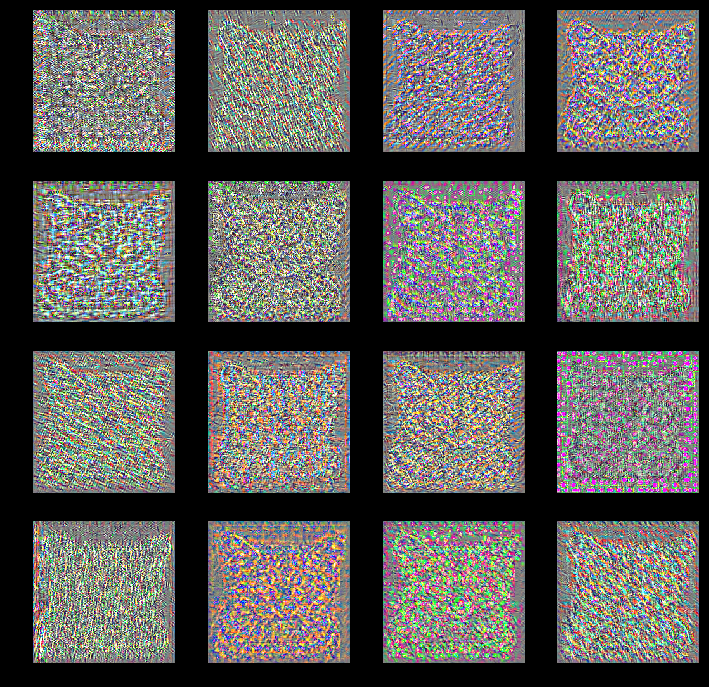

In [51]:
show_feature_maps(img_cat, 4)

## Третий слой

C:\Users\d.soloviev\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\autograd\__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


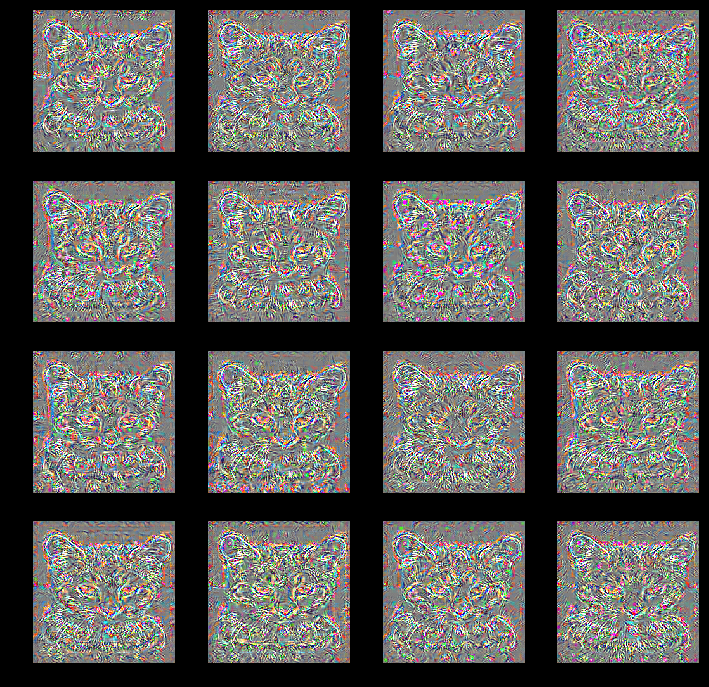

In [52]:
show_feature_maps(img_cat, 7)

## Пятый слой

C:\Users\d.soloviev\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\autograd\__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


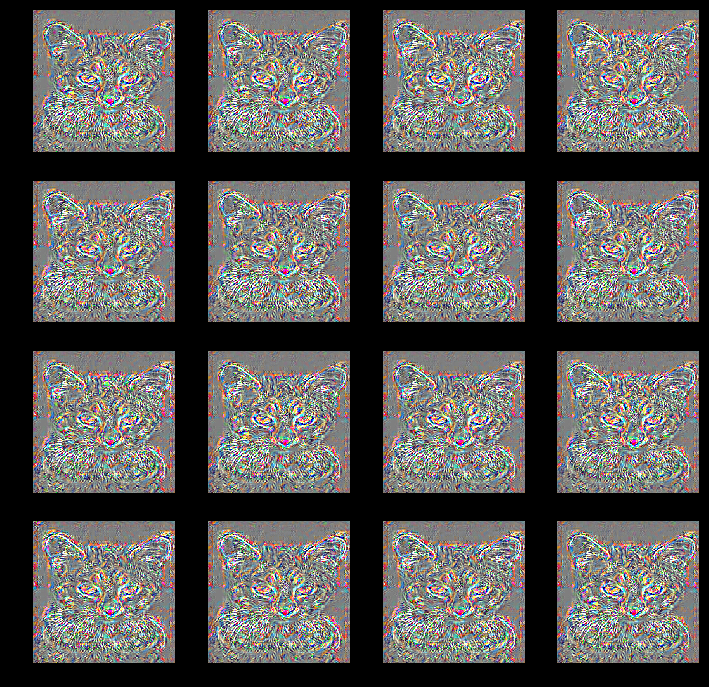

In [53]:
show_feature_maps(img_cat, 11)

Далее можно рассматривать каждый фильтр в отдельности тогда мы получим следующие картинки. 
![GaborFilter](./img/GaborFilter.png)
Видно, что на третьем слое у нас появляются фильтры Габора. На верхних слоях мы должны получить что то похожее на:
![TopLayers](./img/TopLayers.png)
Т.е. каждый нейрон, уже практически отвечает за все изображение. 
<br/>Сложение прередставлении по всему каналу, дает изображения, которые получили выше

# Визуализация фичей при помощи Gradiemt Ascent
[Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf)
<br/>
В предыдущем подходе, мы визуализтровали значение градиента по после последлено слоя сети. Что если использовать картинку, которую можно обновлять. Т.е. задача получить изображение на картинке, которое вызывает заданную активацию, т.е. максимизировать вход по выходу.
$$ I^* = arg max ( S(I) - \lambda ||I||^{2} _{2}) $$ 
* S(I) - наша функция, т.е. нейросеть
* R(I) - регуляризатор, который не позволяет сгенерировать "неестественное" изображение

Gradient Ascent -  нам нужно найти такое изображение, которое бы максимизировало вероятность нашего класса. <br/>

### Алгоритм:
1. Инициализируем картинку нулями

2. Повторяем
    1. Пропускаем картинку через сеть получаем f(x)
    2. Делаем обратное распространение ошибки по выходу интересующего нас нейрона
    3. Делаем обновление картинки


In [3]:
# функции для препроцессинга и пост процессинга изображения используем torchvision helper functions
img_size = 224

postpa = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0],
                             std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                             std=[1,1,1]),
    ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): 
    # клипаем результат в диапазоне [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

---
* Заменяем восстанавливаем ReLU функции

In [4]:
for idx, module in AlexNet.features._modules.items():
    if module.__class__.__name__ is 'GuidedBackpropReLU':
        AlexNet.features._modules[idx] = nn.ReLU()
        

* Инициализируем картинку

In [6]:
in_img = Variable( torch.zeros(1, 3, 224, 224), requires_grad=True) 

Поскольку решаем задачу оптимзации, инициализируем оптимизатор

In [34]:
optimizer = torch.optim.SGD([in_img], lr=1)

In [35]:
# какой класс нас интересует
target_class = 281 # котик
# коэффициент регуляризации
l2_descent = 1e3

Оптимизируем, используя gradient descent, $$ I^* = arg min ( - S(I) + \lambda ||I||^{2} _{2}) $$ 

In [36]:

for n_iter in range(0, 100):
    optimizer.zero_grad()
    out = AlexNet(in_img)
    class_loss = -out[0,target_class] 
    l2_loss = l2_descent * (in_img**2).mean()
    loss = class_loss + l2_loss 
    sys.stdout.write('\riter: %d, total loss: %.3f, class loss: %.3f, l2 loss: %.3f'%(n_iter, loss.data[0], class_loss.data[0], l2_loss.data[0]))
    loss.backward(retain_graph=True)
    optimizer.step()
    

iter: 99, total loss: -139.463, class loss: -191.351, l2 loss: 51.887

Жутко котики...

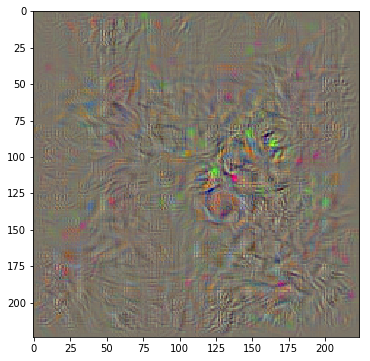

In [43]:
plt.figure(1, (6, 6))
plt.imshow(postp(in_img.data.clone().squeeze()))
plt.show()

  ## Дополнительные регуляризации
 [Understanding Neural Networks Through Deep Visualization](http://yosinski.com/media/papers/Yosinski__2015__ICML_DL__Understanding_Neural_Networks_Through_Deep_Visualization__.pdf). Рассматриваем L2 регуляризацию как обобщенный регуляризационный терм
  
  $$ I^* = arg max ( S(I) - R_{\theta}(I)) $$ 
  $$ r(*) $$
  Тогда обновление картинки можно рассматривать через регуляризацию
  $$ I^* <- r(I+\eta \frac{dS_i}{dI}) $$ 
  
  ### Регуляоизации
  * L2 регуляризация добавляем ее в виде:
   $$ r_{\theta} = (1-\theta) * I $$
  * Gaussian blur
  * Clip пикселей с маленькой нормой
  * Clip пикселей с маленьким вкладом

## Определяем дополнительные функции

In [5]:
# Уменьшаем коэффициент обучения.
def decay_lr(optimizer, factor):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= factor 

# L2 decay регуляризация 
def l2_decay(img, theta):
    img.data *= (1-theta)


# Гаусов шум, как модуль нужно считать градиент по нему
class gauss_blur(nn.Module):
    def __init__(self, sigma):
        super(gauss_blur, self).__init__()
        kernel_size = 11 #hardcode this here
        ks_h = int((kernel_size-1)/2) #for convenience
        self.blur_pad = nn.ReplicationPad2d(ks_h)
        self.blur_x = nn.Conv2d(3, 3, kernel_size=(1,kernel_size), groups=3, padding=0, bias=False)
        self.blur_y = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1), groups=3, padding=0, bias=False)
        #Инициализируем веса
        gaussian = (1./np.sqrt(2*np.pi*sigma**2) * np.exp(-np.arange(-ks_h, ks_h+1)**2/(2.*sigma**2))).astype(np.float32)
        gaussian = np.tile(gaussian[None,None,None,:],(3,1,1,1))
        gaussian = torch.from_numpy(gaussian)
        list(self.blur_x.parameters())[0].data = gaussian.clone()
        list(self.blur_y.parameters())[0].data = gaussian.transpose(2,3).clone()
        
    def forward(self, x):
        x = self.blur_pad(x)
        x = self.blur_x(x)
        x = self.blur_y(x)
        return x

#Блюрим картинку
def blur_image(img, blur):
    img.data = blur(img).data

#Клип пикселей м маленькой нормой
def clip_norm(img, percent):
    all_norms = torch.sqrt((img.data**2).sum(1))
    k = int(percent/100. * all_norms.view(-1).size(0))
    ndx = all_norms.le(torch.kthvalue(all_norms.view(-1), k)[0][0])
    img.data[ndx.expand_as(img.data)] = 0
    
#Клип пикселей с маленьким произведением на градиент
def clip_grad(img, percent):
    all_norms = torch.abs(img.data*img.grad.data).sum(1)
    k = int(percent/100. * all_norms.view(-1).size(0))
    ndx = all_norms.le(torch.kthvalue(all_norms.view(-1), k)[0][0])
    img.data[ndx.expand_as(img.data)] = 0

def mask_image(img, mask):
    img.data = img.data * mask.data


def avg_color(img):
    img.data = img.data.mean(1).expand_as(img.data)

## Задаем параметры оптимизации
Картинку берем не нули, а рандомный шум, как еще один элемент регуляризации
[Классы ImageNet](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

In [45]:
#Задаем картинку для оптимизации 
cat_img = Variable(1e-2 * torch.randn(1, 3, img_size, img_size), requires_grad=True)

# Основные параметры оптимизации
max_iter = 300 # количество итераций
lr = 1e2 # начальный коэффициент обучени, который будем снижать
momentum = 0 # параметр момента
optimizer = torch.optim.SGD([cat_img], lr=lr, momentum=momentum)
target_class = 1 # рыбки золотые

#параметры уменьшения коэффициента обучения
# max_iter - коэффициент не уменьшается
decay_iter = max_iter # количество итераций через которые будет уменьшаться lr 
decay_factor = 1e-1 # фактор на который умножаем коэфиициент обучения

# параметры регуляризации
#l2 decay parameters
l2_decay_iter = 1  # количество итераций через которое будет применятся регуляризационный терм
theta_decay = 1e-2 # коэффициент сброса

# параметры блюра
blur_iter = 1 # через какое количество итераций мы блюрим картинку
sigma = 1 #std гаусова кернела
blur = gauss_blur(sigma) # модуль блюра

# параметры обрезки
clip_norm_iter = 1
percent_norm = 20 # персентиль, в который попадают значения для клиппинга
clip_grad_iter = 1
percent_grad = 20


## Запускаем оптимизацию

In [46]:

for n_iter in range(max_iter):
    optimizer.zero_grad()
    output = AlexNet(cat_img)
    loss = -output[0,target_class]

    sys.stdout.write('\riter: %d, total loss: %.3f, %f'%(n_iter, loss.data[0], torch.max(cat_img.data)))
    
    loss.backward()
    optimizer.step()
    
    # уменьшаем коэффициент обучения
    if n_iter%decay_iter == 0:
        decay_lr(optimizer, decay_factor)
        
    # делаем дополнительные регуляризации
    #l2 регуляризация 
    if n_iter%l2_decay_iter == 0:
        l2_decay(cat_img, theta_decay)
    #blur 
    if n_iter%blur_iter == 0:
        blur_image(cat_img, blur)
        
    #clip значений с маленькой нормой
    if n_iter%clip_norm_iter == 0:
        clip_norm(cat_img, percent_norm)
        
    #clip значений с маленьким вкладом
    if n_iter%clip_grad_iter == 0:
        clip_grad(cat_img, percent_grad)
        
    #multiply mask
    if masking:
        mask_image(cat_img, mask)
        
    #average over colors
    if no_color:
        avg_color(cat_img)


iter: 299, total loss: -238.464, 3.948400

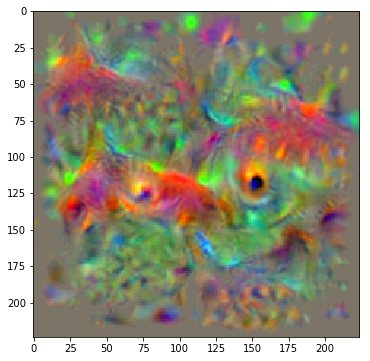

In [47]:
plt.figure(1, (6, 6))
plt.imshow(postp(cat_img.data.clone().squeeze()))
plt.show()

Используя такой-же подход, можно визуализировать нейроны любого слоя.
<br/> 
Вот примерно, что получится
![GradientAscent](./img/GradientAscent.png)

Мы можем использовать такое решение для того, что бы анализировать, что наша нейро сеть выучила в качестве входного изображения для классификации. И таким образом находить фейлы, которые могут случатся в результате обучения
![GradientAscent2.png](./img/GradientAscent2.png)
Так, например, выглядит класс гантели. Видно, что сеть выучила еще и руки, как признак класса

# [DeepDream](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
Используем тот же самы метод Gradient Ascent. Только в этом случае усиливаем действие не одного нейрона а всей группы на слое
1. Пропускаем картинку через сеть
2. Устанавливаем градиент выбранного слоя (не нейрона) равным их активации
3. Делаем backward
4. Обновляем картинку <br/>
В нашем случае функция, которую мы максимизируем
$$ I^* = arg max ( \sum_i f_i (I)^2) $$

Дополнительно, делают, смешения картинки + нормализацию градиента + клип значений пикселей

![DeepDream](./img/DeepDream.png)

---
Можно модифицировать код выше:
* взять нужный слой, заменив AlexNet на FeaturesExtractor
* сделав небольшие смещения входной картинки. 
* на вход подовать не шум, а изображение

In [7]:
# что то вроде этого
#
# net = FeaturesExtractor(, ...)
#
# shift_x, shift_y = np.random.randint(-max_jitter, max_jitter + 1, 2)
# img = np.roll(np.roll(img, shift_x, -1), shift_y, -2)

# ... Считаем градиенты по нужному слою ...

# Возвращаем изображение назад
# img = img_variable.data.cpu().numpy()  # b, c, h, w
# img = np.roll(np.roll(img, -shift_x, -1), -shift_y, -2)
# 

В зависимости от того, какие слои брать можно восстанавливать целые изображения (верхние слои) либо делать орнаменты (нижние слои)
![DeepDream2](./img/DeepDream2.png)

Если взять нейронку, которая обучена на каком либо одном датасете и предъявлять ей изображения объектов которые она никогда не видела, то она будет восстанавливать выученные изображения
![DeepDream](./img/DeepDream3.png)

Можно днелать такой же фокус но с рандомным шумом, тогда получим полный __ Dream __
![DeepDream4](./img/DeepDream4.png)
Сеть обучали на Google Places

# Как обдурить нейронную сеть?
Мы плавно подошли к тому, что можно вместо шума подавать сети реальную картинку, котору можно модифицировать так, что бы сместить ее в другой класс
Процедура очень схожа с тем, что мы прделывали выше
![FoolingImages.png](./img/FoolingImages.png)

# Синтез текстур

# Что такое Матрица Грамма
![TextureSynthesis](./img/TextureSynthesis.png)

* Каждый слой CNN задает C каналов, каждый канал имеет размерность H x W. Канал (фиче мапу) можно векторизовать, как показано на картинке
* Произведение матриц Сx(H\*W), получившихся из векторизованных каналов, друг на друга датут __ матрицу грамма __ размерностью CxC
<br/> По сути матрица грамма является матрицей взаимных корреляций фичей каналов. Близкие по текстуре картинке будут иметь пблизкие матрицы грамма.

# Алгоритм синтеза текстур
1. Отбираем нужный нам слой нейросети. Например пятый слой VGG
2. Пропускаем текстуру, которую мы хотим синтезировать считаеми запоминаем получившуюся матрицу грамма на отобранном слое
 $$ G^{l}_{ij} = \sum_k F^{l} _{ik} F^{l}_{jk} $$ 
3. Инициализируем картинку рандомом, как делали ранее
4. Пропускаем картинку через сеть, считаем на слое l получившуюся матрицу грамма
5. Считаем ошибку $$ || G^{l} - G^{l*} || ^2_2 $$
6. Делаем backprop ошибки
7. Обновляем картинку
8. GOTO 4

![TextureSynthesis2](./img/TextureSynthesis2.png)

# Пример реконструкции текстур
![TextureSynthesis](./img/TextureSynthesis3.png)

# Neural Texture Synthesis: Texture = Artwork
![NeuralStyle](./img/NeuralStyle.png)
Если прогонять через сеть полотна художников, пытаясь синтезировать тектуты, то сеть будет находить в них текстурные патерны, характерные для данных картин

# Neural Style Transfer (Texture + Content)
[“Image style transfer using convolutional neural networks". Gatys]
![NeuralStyle2.png](./img/NeuralStyle2.png)
В то-же время, если мы будем пытаться приближать фичи рандомного шума к фичам оригинальной картинки на слое сети, оптимизируя L2 loss между фичами на слое полученными от оригинальной картинки и фичами получеными от синтезированной картинки, то получим восстановленые изображения 

Комбинируя лосы из двух методов $$ Loss = L_G + L_F $$ $$ L_G = || G^{l} - G^{l*} || ^2_2 $$ $$ L_F =  || F^{l} - F^{l*} || ^2_2 $$ Получим исходное изображение, с наложенным на него стилем

![NeuralStyle3](./img/NeuralStyle3.png)

![NeuralStyle4.png](./img/NeuralStyle4.png)

Если взвешивать ошибку не равномерно, то можно регуоллировать сколько стиля или контента добавлять.
![NeuralStyle5.png](./img/NeuralStyle5.png)

# [Fast Style Transfer](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)
Прооблема предложенного трансфера стиля - он очен медленный. Требует достаточно большое количество итераций для прорисовки финальной картинки. Можно обучить нейросеть генерировать картинку за один проход.

![NeuralStyle6.png](./img/NeuralStyle6.png)

# Итого
И зучили различные методы понимания представления нейросетей

### Активация: 
  * Максимизация патчами
  * Поиск активности перекрытием
  
### Градиенты:
  * Saliency maps, 
  * Визуализация классов
  * Fooling - обман сети
  
### Для души: 
   * DeepDream
   * Style Transfer

$$ Loss = || G^{l} - G^{l*} || ^2_2 $$
---
 $$ L_G = || G^{l} - G^{l*} || ^2_2 $$ $$ L_F =  || F^{l} - F^{l*} || ^2_2 $$ $$ Loss = L_G + L_F $$
 ---